In [0]:
import numpy as np
import matplotlib.pyplot as plt
import random
from random import randrange

from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn import model_selection

from graphviz import Digraph

## functions

In [0]:
def calc_gini(x, y, t):
    qty_all = len(y)
    qty_left = len(y[x < t])
    qty_right = qty_all - qty_left

    if qty_left == 0 or qty_right == 0:
        return np.inf

    qty0_left = ((y[x < t]) == 0).sum()
    qty0_right = ((y[x >= t]) == 0).sum()
    
    p0_left = qty0_left / qty_left
    p1_left = 1 - p0_left

    p0_right = qty0_right / qty_right
    p1_right = 1 - p0_right
    
    left_coef = qty_left / qty_all

    h_left = p0_left * (1 - p0_left) + p1_left * (1 - p1_left)
    h_right = p0_right * (1 - p0_right) + p1_right * (1 - p1_right)

    res = left_coef * h_left + (1 - left_coef) * h_right
    return res

def gini(labels):
    #  count quant of objects in classes
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    # calc the criteria
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

# cacl the quality
def quality(left_labels, right_labels, current_gini):

    # share of the sample in the left side
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

# implement Node class
class Node:   
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index # index of the defined feature
        self.t = t # threshold meaning
        self.true_branch = true_branch # sub-tree complied with the threshold
        self.false_branch = false_branch # sub-tree complied with the threshold

# implement Leaf class
class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        # calc the quant of object of the different classes
        classes = {}  
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        # return class with max objects in the leaf
        prediction = max(classes, key=classes.get)

        return prediction

# split of the dataset in a node
def split(data, labels, index, t):

    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

# finding the best split
def find_best_split(data, labels):

    # min quant of the object in a node
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None

    n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  skipping split if less than 5 object in a leaf
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue

            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  select threshold with max of the quality increase
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

# building tree with the recursive function
def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  base case - stop the recursion
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # two trees built recursively
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    return Node(index, t, true_branch, false_branch)

# model itself
def classify_object(obj, node):

    #  stop recursion when leaf encountered
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

# printing out the tree
def print_tree(node, spacing=''):

    # if a leaf - predict
    if isinstance(node, Leaf):
        print(spacing + 'Прогноз:', node.prediction)
        return

    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + '  ')

    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + '  ')

# accuracy function
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0


In [0]:
def calc_gini(x, y, t):
    qty_all = len(y)
    qty_left = len(y[x < t])
    qty_right = qty_all - qty_left

    if qty_left == 0 or qty_right == 0:
        return np.inf

    qty0_left = ((y[x < t]) == 0).sum()
    qty0_right = ((y[x >= t]) == 0).sum()
    
    p0_left = qty0_left / qty_left
    p1_left = 1 - p0_left

    p0_right = qty0_right / qty_right
    p1_right = 1 - p0_right
    
    left_coef = qty_left / qty_all

    h_left = p0_left * (1 - p0_left) + p1_left * (1 - p1_left)
    h_right = p0_right * (1 - p0_right) + p1_right * (1 - p1_right)

    res = left_coef * h_left + (1 - left_coef) * h_right
    return res

def gini(labels):
    #  count quant of objects in classes
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    # calc the criteria
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

# cacl the quality
def quality(left_labels, right_labels, current_gini):

    # share of the sample in the left side
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

# implement Node class
class Node:   
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index # index of the defined feature
        self.t = t # threshold meaning
        self.true_branch = true_branch # sub-tree complied with the threshold
        self.false_branch = false_branch # sub-tree complied with the threshold

# implement Leaf class
class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        # calc the quant of object of the different classes
        classes = {}  
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        # return class with max objects in the leaf
        prediction = max(classes, key=classes.get)

        return prediction

# split of the dataset in a node
def split(data, labels, index, t):

    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

# finding the best split
def find_best_split(data, labels):

    # min quant of the object in a node
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None

    n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  skipping split if less than 5 object in a leaf
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue

            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  select threshold with max of the quality increase
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

# building tree with the recursive function
def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  base case - stop the recursion
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # two trees built recursively
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    return Node(index, t, true_branch, false_branch)

# model itself
def classify_object(obj, node):

    #  stop recursion when leaf encountered
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

# printing out the tree
def print_tree(node, spacing=''):

    # if a leaf - predict
    if isinstance(node, Leaf):
        print(spacing + 'Прогноз:', node.prediction)
        return

    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + '  ')

    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + '  ')

# accuracy function
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0


## data upload

In [0]:
classification_data, classification_labels = datasets.make_classification(n_features = 2, 
                                                                          n_informative = 2,
                                                                          n_classes = 2, 
                                                                          n_redundant=0,
                                                                          n_clusters_per_class=1, 
                                                                          random_state=5)

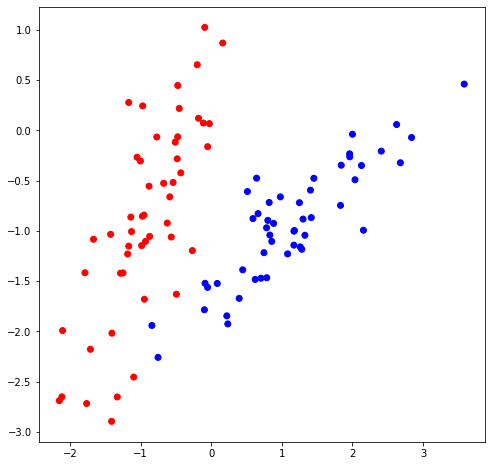

In [5]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap('lightcoral', 'lightblue')

plt.figure(figsize=(8, 8))
plt.scatter(
    list(
        map(
            lambda x: x[0], classification_data
        )
    ),
    list(
        map(
            lambda x: x[1], classification_data
        )
    ),
    c = classification_labels,
    cmap=colors
)



In [0]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                    classification_labels, 
                                                                                    test_size = 0.3,
                                                                                    random_state = 5)

## build & predict

In [7]:
my_tree = build_tree(train_data, train_labels)

print_tree(my_tree)

Индекс 0
Порог -0.02676286201867817
--> True:
  Индекс 0
  Порог -0.11161924805848533
  --> True:
    Прогноз: 0
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [8]:
train_answers = predict(train_data, my_tree)
test_answers = predict(test_data, my_tree)

print(train_answers)
print(test_answers)

[0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1]
[0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0]


In [9]:
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, test_answers)

print(train_accuracy)
print(test_accuracy)

97.14285714285714
86.66666666666667


# 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)  

In [75]:
# функция для кросс валидации
def cross_validation_split(dataset, n_folds):
	dataset_split = []
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	# через цикл формирую случайно фолды, 
	# дропаю из исходного списка и скадываю в новый
	for i in range(n_folds):
		fold = []
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split
 
# функция для метрики
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / len(actual)

# расчет коэф джини для каждой разбивки
def gini_index(groups, classes):
	# считаю кол-во объектов в каждой разбивке
	n_instances = float(sum([len(group) for group in groups]))
	
	gini = 0
	for group in groups:
		size = float(len(group))
		# исключение деления на ноль
		if size == 0:
			continue
		score = 0
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# взвегиваю значение коэф на размер группы
		gini += (1.0 - score) * (size / n_instances)
	
	return gini

# функция базового случая
def to_terminal(group):
	outcomes = [row[-1] for row in group]
	return max(set(outcomes), key=outcomes.count)
 
# функция ветвления дерева до наступления базовго случая
# через аргументы задаю максимальную глубину и минимальный размер
def split(node, max_depth, min_size, depth):
	left, right = node['groups']
	del(node['groups'])
	# проверка базового случая
	if not left or not right:
		node['left'] = node['right'] = to_terminal(left + right)
		return
	# проверка макс глубины
	if depth >= max_depth:
		node['left'], node['right'] = to_terminal(left), to_terminal(right)
		return
	
	# разбивка по веткам
	if len(left) <= min_size:
		node['left'] = to_terminal(left)
	else:
		node['left'] = get_split(left)
		split(node['left'], max_depth, min_size, depth+1)

	if len(right) <= min_size:
		node['right'] = to_terminal(right)
	else:
		node['right'] = get_split(right)
		split(node['right'], max_depth, min_size, depth+1)
 
# разбивка датасета исходя из значений объектов
def test_split(index, value, dataset):
	left, right = [], []
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	
	return left, right
 
# функция определения наилучшего разбиения
def get_split(dataset):
	# вытаскиваю классы
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = 999, 999, 999, None
	# в цикле для каждого объекта выборки
	# считаю коэф джини и выбираю наименьший (по условиям определения его в формуле)
	for index in range(len(dataset[0])-1):
		for row in dataset:
			groups = test_split(index, row[index], dataset)
			gini = gini_index(groups, class_values)
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
	
	return {'index':b_index, 'value':b_value, 'groups':b_groups}


# функция построения дерева
# через аргументы определяю размер и глубину
def build_tree(train, max_depth, min_size):
	root = get_split(train)
	split(root, max_depth, min_size, 1)
	
	return root

# функция для дерева решений
def decision_tree(train, test, max_depth, min_size):
	tree = build_tree(train, max_depth, min_size)
	predictions = []
	for row in test:
		prediction = predict(tree, row)
		predictions.append(prediction)
  
	return predictions

# функция предсказания
def predict(node, row):
	if row[node['index']] < node['value']:
		if isinstance(node['left'], dict):
			return predict(node['left'], row)
		else:
			return node['left']
	else:
		if isinstance(node['right'], dict):
			return predict(node['right'], row)
		else:
			return node['right']
 
# функция запуска модели для всех фолдов
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = []
	# в цикле запускаю алгоритм на разных наборах фолдов
	for fold in folds:
		# из выборки удаляю тестовый фолд
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		# формирую тест
		test_set = []
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		# предсказываю через дерево 
		predicted = algorithm(train_set, test_set, *args)
		# считаю метрику
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
  
	return scores

my_data = np.column_stack((classification_data, classification_labels))

random.seed(42)
n_folds = 5
max_depth = 5
min_size = 10

scores = evaluate_algorithm(
	  my_data.tolist(),
	  decision_tree,
	  n_folds, 
	  max_depth, 
	  min_size
)
print(f'точность на фолдах {scores}\nсредняя точность: {sum(scores)/float(len(scores))}')

точность на фолдах [0.95, 0.9, 0.85, 0.9, 0.95]
средняя точность: 0.9099999999999999


#### попробовал увеличить кол-во признаков

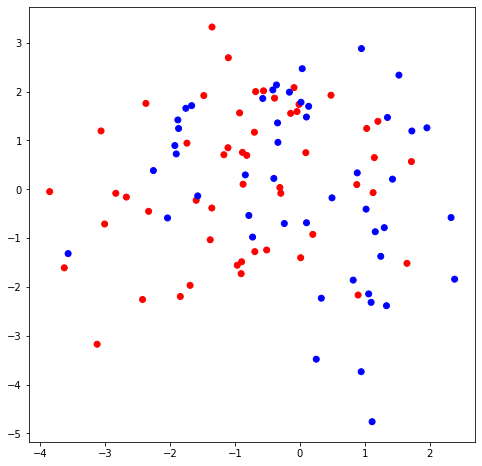

In [76]:
classification_data, classification_labels = datasets.make_classification(n_features = 4, 
                                                                          n_informative = 4,
                                                                          n_classes = 4, 
                                                                          n_redundant=0,
                                                                          n_clusters_per_class=1, 
                                                                          random_state=42)

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap('lightcoral', 'lightblue')

plt.figure(figsize=(8, 8))
plt.scatter(
    list(
        map(
            lambda x: x[0], classification_data
        )
    ),
    list(
        map(
            lambda x: x[1], classification_data
        )
    ),
    c = classification_labels,
    cmap=colors
)



In [77]:
# функция для кросс валидации
def cross_validation_split(dataset, n_folds):
	dataset_split = []
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	# через цикл формирую случайно фолды, 
	# дропаю из исходного списка и скадываю в новый
	for i in range(n_folds):
		fold = []
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split
 
# функция для метрики
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / len(actual)

# расчет коэф джини для каждой разбивки
def gini_index(groups, classes):
	# считаю кол-во объектов в каждой разбивке
	n_instances = float(sum([len(group) for group in groups]))
	
	gini = 0
	for group in groups:
		size = float(len(group))
		# исключение деления на ноль
		if size == 0:
			continue
		score = 0
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# взвегиваю значение коэф на размер группы
		gini += (1.0 - score) * (size / n_instances)
	
	return gini

# функция базового случая
def to_terminal(group):
	outcomes = [row[-1] for row in group]
	return max(set(outcomes), key=outcomes.count)
 
# функция ветвления дерева до наступления базовго случая
# через аргументы задаю максимальную глубину и минимальный размер
def split(node, max_depth, min_size, depth):
	left, right = node['groups']
	del(node['groups'])
	# проверка базового случая
	if not left or not right:
		node['left'] = node['right'] = to_terminal(left + right)
		return
	# проверка макс глубины
	if depth >= max_depth:
		node['left'], node['right'] = to_terminal(left), to_terminal(right)
		return
	
	# разбивка по веткам
	if len(left) <= min_size:
		node['left'] = to_terminal(left)
	else:
		node['left'] = get_split(left)
		split(node['left'], max_depth, min_size, depth+1)

	if len(right) <= min_size:
		node['right'] = to_terminal(right)
	else:
		node['right'] = get_split(right)
		split(node['right'], max_depth, min_size, depth+1)
 
# разбивка датасета исходя из значений объектов
def test_split(index, value, dataset):
	left, right = [], []
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	
	return left, right
 
# функция определения наилучшего разбиения
def get_split(dataset):
	# вытаскиваю классы
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = 999, 999, 999, None
	# в цикле для каждого объекта выборки
	# считаю коэф джини и выбираю наименьший (по условиям определения его в формуле)
	for index in range(len(dataset[0])-1):
		for row in dataset:
			groups = test_split(index, row[index], dataset)
			gini = gini_index(groups, class_values)
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
	
	return {'index':b_index, 'value':b_value, 'groups':b_groups}


# функция построения дерева
# через аргументы определяю размер и глубину
def build_tree(train, max_depth, min_size):
	root = get_split(train)
	split(root, max_depth, min_size, 1)
	
	return root

# функция для дерева решений
def decision_tree(train, test, max_depth, min_size):
	tree = build_tree(train, max_depth, min_size)
	predictions = []
	for row in test:
		prediction = predict(tree, row)
		predictions.append(prediction)
  
	return predictions

# функция предсказания
def predict(node, row):
	if row[node['index']] < node['value']:
		if isinstance(node['left'], dict):
			return predict(node['left'], row)
		else:
			return node['left']
	else:
		if isinstance(node['right'], dict):
			return predict(node['right'], row)
		else:
			return node['right']
 
# функция запуска модели для всех фолдов
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = []
	# в цикле запускаю алгоритм на разных наборах фолдов
	for fold in folds:
		# из выборки удаляю тестовый фолд
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		# формирую тест
		test_set = []
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		# предсказываю через дерево 
		predicted = algorithm(train_set, test_set, *args)
		# считаю метрику
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
  
	return scores

my_data = np.column_stack((classification_data, classification_labels))

random.seed(42)
n_folds = 5
max_depth = 5
min_size = 10

scores = evaluate_algorithm(
	  my_data.tolist(),
	  decision_tree,
	  n_folds, 
	  max_depth, 
	  min_size
)
print(f'точность на фолдах {scores}\nсредняя точность: {sum(scores)/float(len(scores))}')

точность на фолдах [0.55, 0.7, 0.35, 0.6, 0.65]
средняя точность: 0.5700000000000001
